This notebook plots timeseries of global-mean T200, T850 and total water path in year-long prognostic runs. It depends on diagnostics computed by the `prognostic-reports` workflow.

It generates Figure S5.

In [1]:
import xarray as xr
import fsspec
import os
import matplotlib.pyplot as plt
from vcm.calc import thermo
from dask.distributed import Client
plt.rcParams['figure.dpi'] = 300
xr.set_options(keep_attrs=True)

In [2]:
Client()

Client Scheduler: tcp://127.0.0.1:46371 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 31.56 GB


### Open pre-computed diagnostics

In [3]:
urls = {
    'baseline': 'gs://vcm-ml-public/argo/2020-11-10-n2o-climate-runs/baseline/diags.nc',
    'rf-control': 'gs://vcm-ml-public/argo/2021-03-15-n2o-climate-runs/rf-control/diags.nc',
    'rf-dQ1-dQ2-only': 'gs://vcm-ml-public/argo/2021-03-15-n2o-climate-runs/rf-dQ1-dQ2-only/diags.nc',
}
variables = ['pwat', 'tmp850', 'tmp200']

In [4]:
variables_to_keep = [
    f"{v}_{reduction}_dycore_global"
    for reduction in ["spatial_mean", "mean_bias"]
    for v in variables
]
diags = []
for run, url in urls.items():
    with fsspec.open(url) as f:
        ds = xr.open_dataset(f).load()
        diags.append(ds[variables_to_keep].assign_coords(experiment=run))
diags = xr.concat(diags, dim='experiment')

In [5]:
baseline = diags.sel(experiment='baseline')
verif = xr.Dataset()
for varname in variables:
    verif_array = baseline[f"{varname}_spatial_mean_dycore_global"] - baseline[f"{varname}_mean_bias_dycore_global"]
    verif[f"{varname}_spatial_mean_dycore_global"] = verif_array
verif = verif.assign_coords(experiment='verification')

In [6]:
diags = xr.concat([verif, diags], dim='experiment').load()

### Open 3D fields necessary to compute MSE

In [7]:
urls_3d = {
    'verification': 'gs://vcm-ml-experiments/2020-10-30-nudge-to-obs-GRL-paper/nudge-to-obs-run-3hr-diags/after_physics.zarr',
    'baseline': 'gs://vcm-ml-experiments/2020-10-30-nudge-to-obs-GRL-paper/baseline-run-2016/atmos_4xdaily.zarr',
    'rf-control': 'gs://vcm-ml-experiments/2021-03-15-nudge-to-obs-GRL-paper-rev1/rf-control/prognostic_run/atmos_4xdaily.zarr',
    'rf-dQ1-dQ2-only': 'gs://vcm-ml-experiments/2021-03-15-nudge-to-obs-GRL-paper-rev1/rf-dQ1-dQ2-only/prognostic_run/atmos_4xdaily.zarr',
}

In [8]:
TEMP='air_temperature'
SPHUM='specific_humidity'
DELZ='vertical_thickness_of_atmospheric_layer'
DELP='pressure_thickness_of_atmospheric_layer'
diags_3d = []

for run, url in urls_3d.items():
    m = fsspec.get_mapper(url)
    ds = xr.open_zarr(m, consolidated=True)
    if run != 'verification':
        ds = ds.rename(grid_xt='x', grid_yt='y', grid_x='x_interface', grid_y='y_interface', pfull='z', phalf='z_interface')
        ds = ds.rename(sphum=SPHUM, temp=TEMP, delz=DELZ, delp=DELP)
        cellarea = ds.area
        ds[DELZ] = - ds[DELZ]  # different convention for data grabbed via python wrapper versus Fortran diagnostic
    else:
        # grab surface geopotential (which is constant in time) from verification run
        surface_geopotential = ds['surface_geopotential'].isel(time=0).drop('time')
    ds = ds[[SPHUM, TEMP, DELZ, DELP]]
    diags_3d.append(ds.assign_coords(experiment=run))
diags_3d = xr.concat(diags_3d, dim='experiment', join='inner')

In [9]:
cp = 1004.  # J/kg/K
g = 9.81  # m/s2
L = 2.5e6  # J/kg

diags_3d['height'] = thermo.height_at_midpoint(diags_3d[DELZ], surface_geopotential, dim='z')
diags_3d['MSE_T'] = (cp * diags_3d[TEMP]).assign_attrs(units='J/kg', long_name='c_p * temperature')
diags_3d['MSE_Z'] = (g * diags_3d['height']).assign_attrs(units='J/kg', long_name='g * height')
diags_3d['MSE_q'] = (L * diags_3d[SPHUM]).assign_attrs(units='J/kg', long_name='L * specific humidity')
diags_3d['MSE'] = (diags_3d.MSE_T + diags_3d.MSE_Z + diags_3d.MSE_q).assign_attrs(units='J/kg', long_name='MSE')
diags_3d['MSE_column_integral'] = (diags_3d.MSE * diags_3d[DELP]).sum('z') / g
diags_3d['MSE_column_and_global_integral'] = (diags_3d.MSE_column_integral * cellarea).sum(
    ['tile', 'x', 'y']
).assign_attrs(long_name='Total atmospheric MSE', units='J')
MSE_to_plot = diags_3d['MSE_column_and_global_integral'].sel(time='2016').compute()

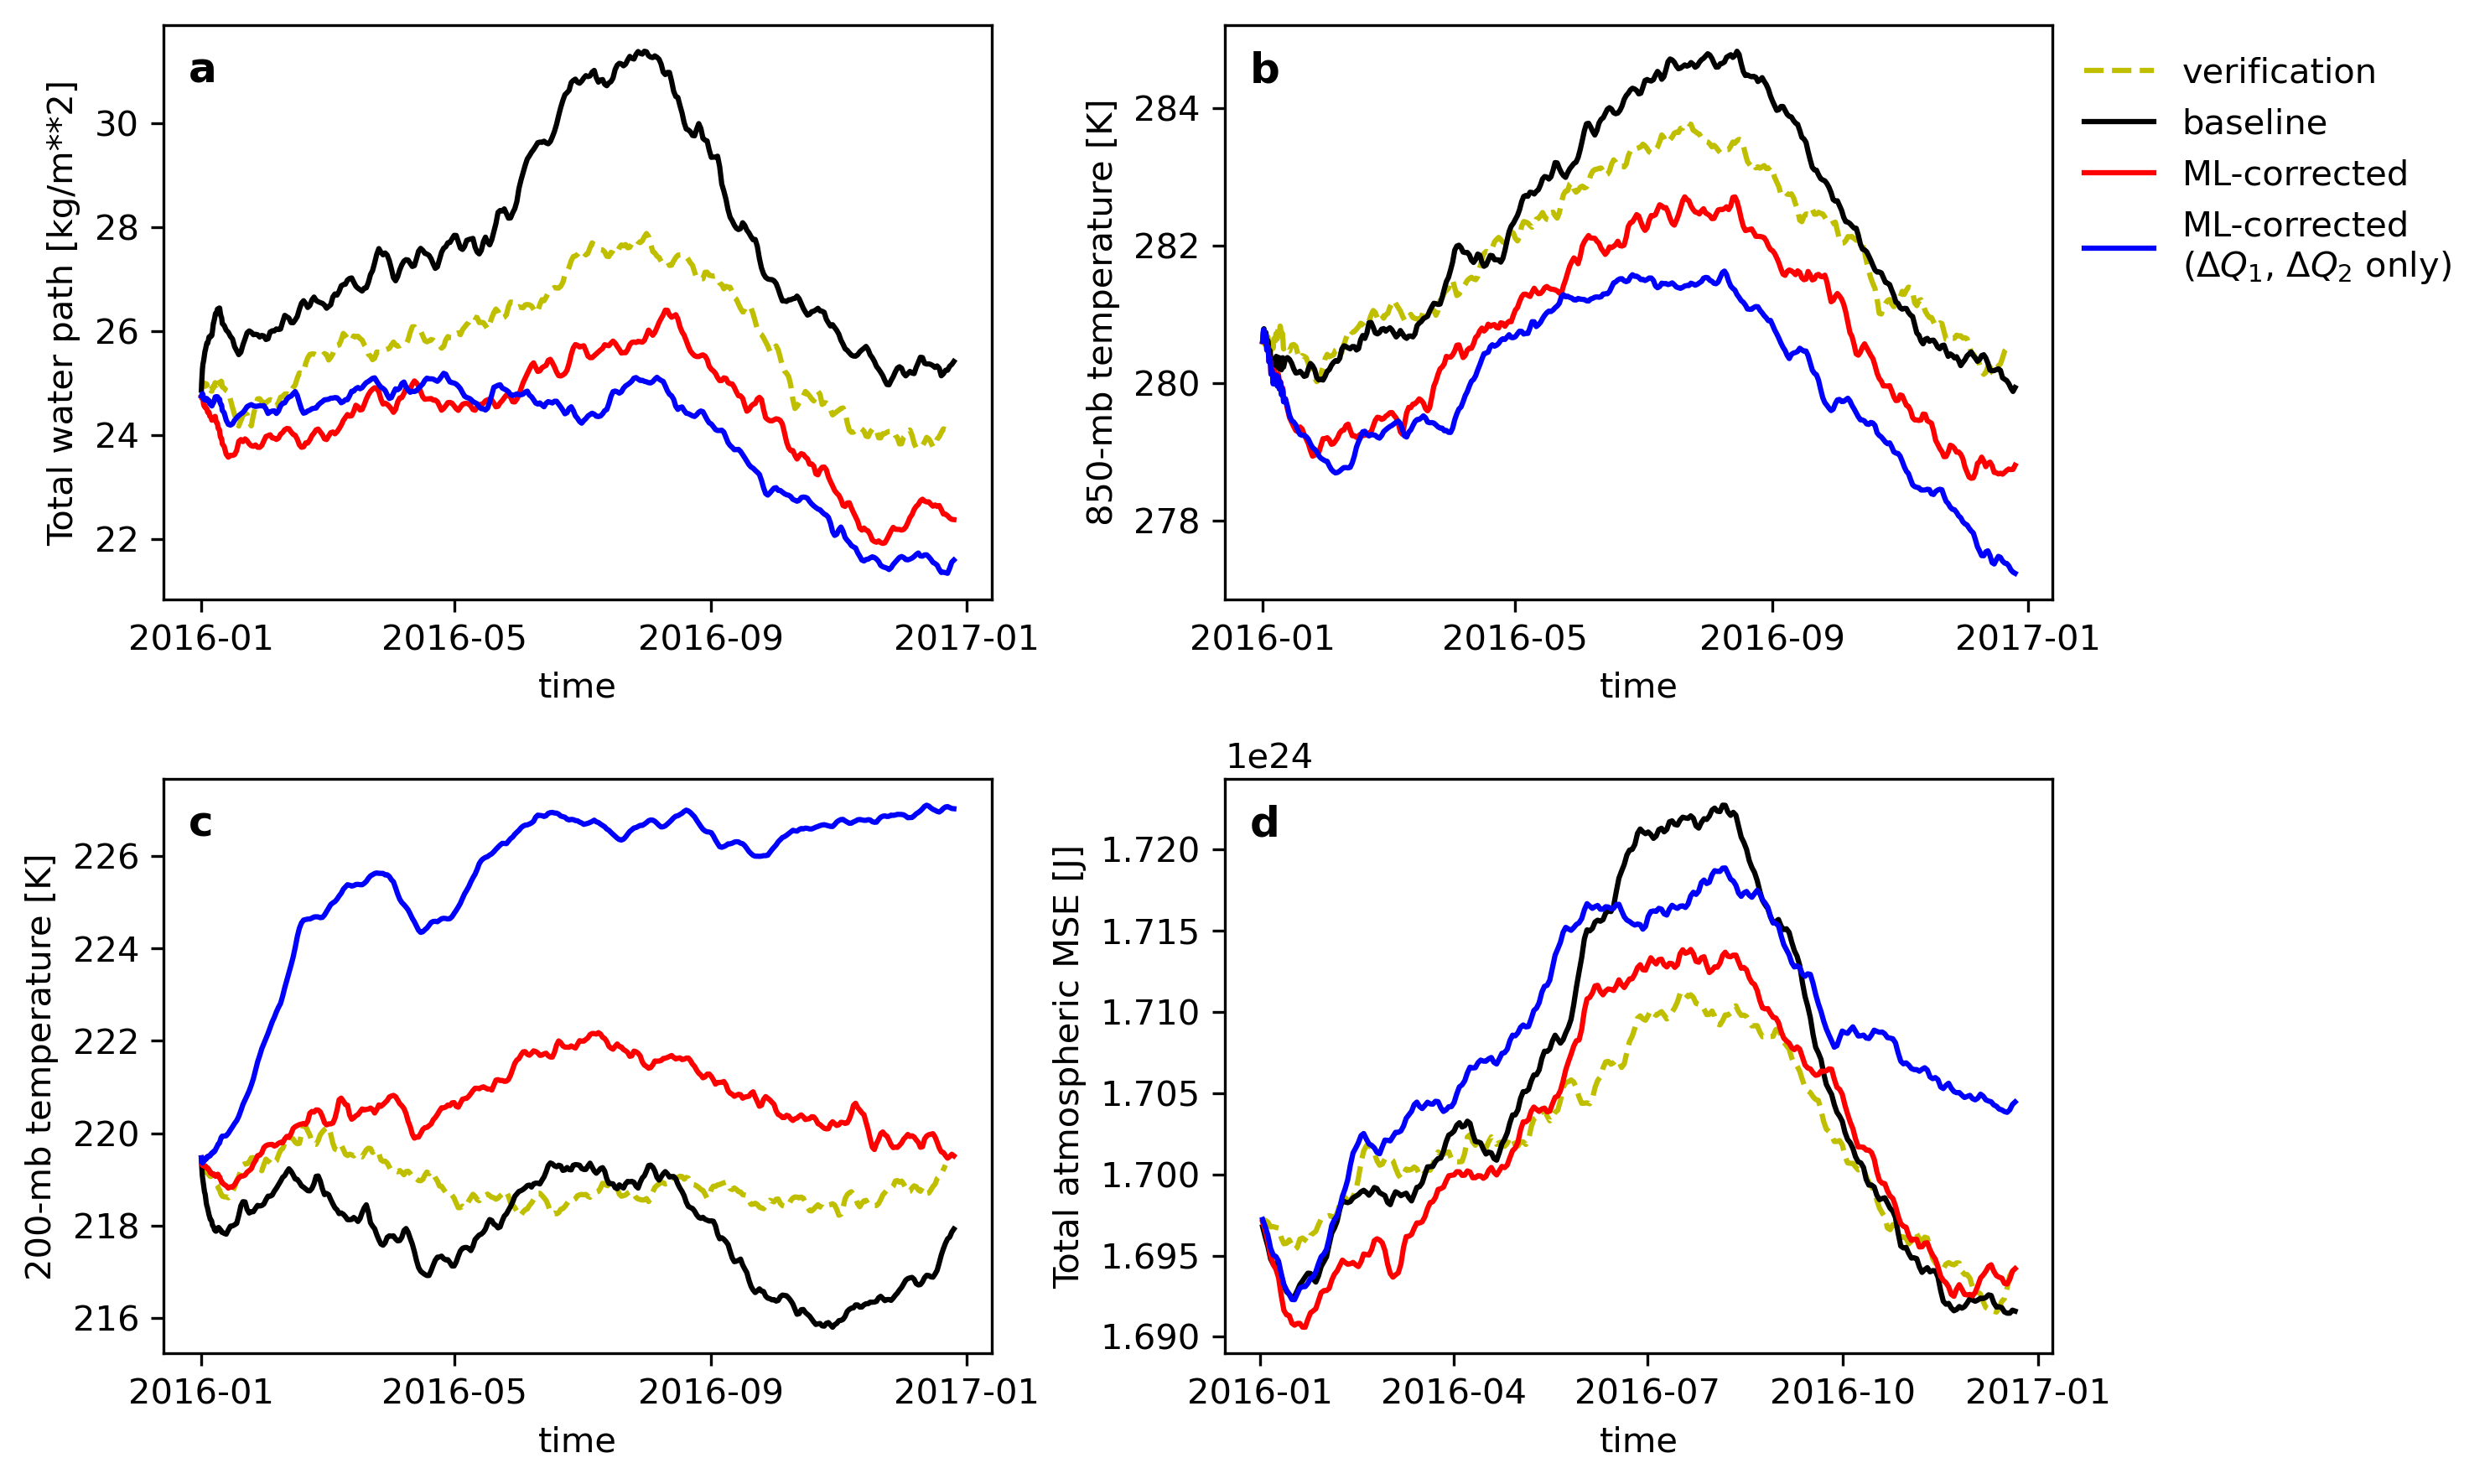

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flat
plot_experiments = ['verification', 'baseline', 'rf-control', 'rf-dQ1-dQ2-only']
labels = ['verification', 'baseline', 'ML-corrected', 'ML-corrected\n($\Delta Q_1$, $\Delta Q_2$ only)']
colors = ['y', 'k', 'r', 'b', 'm']
linestyles = ['--', '-', '-', '-', '-']
titles = ['a', 'b', 'c', 'd']
for j, varname in enumerate(variables + ['MSE_column_and_global_integral']):
    if varname == 'MSE_column_and_global_integral':
        data_to_plot = MSE_to_plot
    else:
        data_to_plot = diags[f"{varname}_spatial_mean_dycore_global"]
    for i, exp in enumerate(plot_experiments):
        data_to_plot.sel(experiment=exp).plot.line(ax=axes[j], label=labels[i], color=colors[i], linestyle=linestyles[i])
    axes[j].text(0.03, 0.9, titles[j], transform=axes[j].transAxes, fontsize=12, fontweight='bold')
    axes[j].set_title('')
    if j == 1:
        axes[j].legend(frameon=False, bbox_to_anchor=(1,1))
plt.tight_layout()